In [1]:
import tensorflow as tf
# current processing
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import Model, layers
from keras.models import Sequential
from keras.layers import preprocessing
from keras.utils import plot_model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import itertools
import shutil
import cv2


from sklearn.metrics import confusion_matrix



2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

random_state_global = 42

pathfinal = path + 'model_history/part_b/'
pathfinal2 = path + 'model_images/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4

IMG_SIZE = (224, 224)
CHANNELS = 3
checkpoint_path = ''
train_dir = 'Group_20/train'
test_dir = 'Group_20/test'
val_dir = 'Group_20/val'

In [3]:
def delete_folder_contents(path_erase):
    '''
    take path to erase all data present on it
    '''
    folder_name = path_erase
    # Get all files in the folder
    files = os.listdir(folder_name)

    # Loop through the files and delete them
    for file in files:
        file_path = os.path.join(folder_name, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            
delete_folder_contents(pathfinal)
delete_folder_contents(pathfinal2)

### Preparing Data

In [4]:
# unzip_data('Group_20.zip')

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir('Group_20')

There are 3 directories and 1 images in 'Group_20'.
There are 5 directories and 0 images in 'Group_20/test'.
There are 0 directories and 20 images in 'Group_20/test/butterfly'.
There are 0 directories and 20 images in 'Group_20/test/helicopter'.
There are 0 directories and 20 images in 'Group_20/test/ketch'.
There are 0 directories and 20 images in 'Group_20/test/brain'.
There are 0 directories and 20 images in 'Group_20/test/ewer'.
There are 5 directories and 0 images in 'Group_20/train'.
There are 0 directories and 50 images in 'Group_20/train/butterfly'.
There are 0 directories and 50 images in 'Group_20/train/helicopter'.
There are 0 directories and 50 images in 'Group_20/train/ketch'.
There are 0 directories and 50 images in 'Group_20/train/brain'.
There are 0 directories and 50 images in 'Group_20/train/ewer'.
There are 5 directories and 0 images in 'Group_20/val'.
There are 0 directories and 10 images in 'Group_20/val/butterfly'.
There are 0 directories and 10 images in 'Group_2

In [5]:
# Setup data inputs
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=True)
train_data = train_ds.map(lambda x, y: (normalization_layer(x), y))


test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle test data for prediction analysis
test_data = test_ds.map(lambda x, y: (normalization_layer(x), y))
test_Y=[]
for images, labels in test_data.unbatch():
    test_Y.append(labels.numpy().argmax())


valid_ds = keras.utils.image_dataset_from_directory(val_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE,
                                                        seed=random_state_global,
                                                        batch_size = batch_size_val,
                                                        shuffle=False) # don't shuffle valid data for prediction analysis
valid_data = valid_ds.map(lambda x, y: (normalization_layer(x), y))

class_names = train_ds.class_names
print(f'\nclass names are {class_names}')

Found 250 files belonging to 5 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.

class names are ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']


2023-05-02 18:27:14.787362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 18:27:14.787483: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-02 18:27:14.910757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
image_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}

flag = True
for image, label in valid_ds.unbatch():
  ind = label.numpy().argmax()
  
  if(len(image_dict[ind]) <= 9):
    image_dict[ind].append(image)
  
  for i in range(5):
    if len(image_dict[i]) != 10:
      flag=False
      break
  
  if(flag==True):
    break

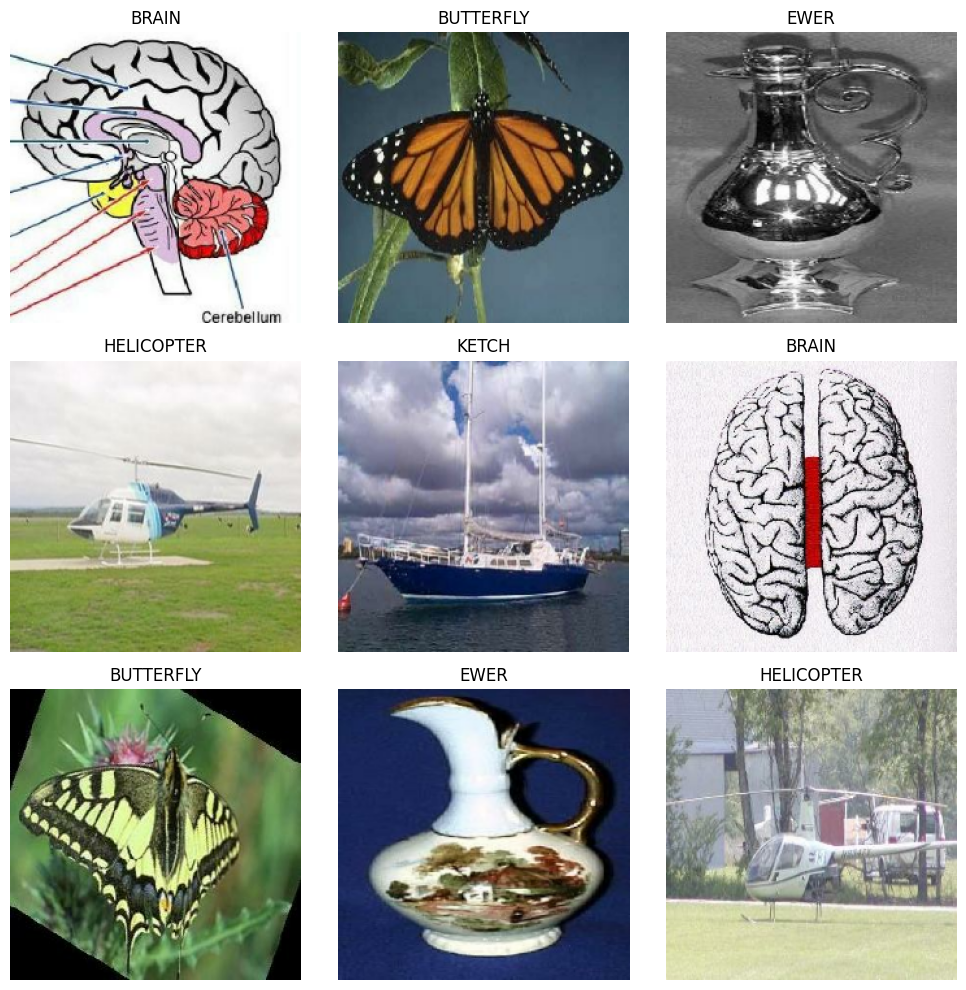

In [7]:
img1, label1 = None, None

fig,ax = plt.subplots(3,3, figsize=(10,10))
ax = ax.reshape(-1)
c=0
for image, label in train_ds.unbatch():
  ind = label.numpy().argmax()
  if((c%5)==ind):
    if(c==1):
      img1, label1 = image, class_names[ind]
    ax[c].imshow(image.numpy().astype("uint8"))
    ax[c].set_title(class_names[ind].upper())
    ax[c].axis("off")
    c+=1
    if(c==9):
      break
plt.tight_layout()
plt.show()

In [8]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=10): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_Y, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)
    

def inferences(df_model_history, model):
    print('\n\n')
    print(f'Training Accuracy for model: {df_model_history["accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Validation Accuracy for model: {df_model_history["val_accuracy"].to_list()[-1]*100:.2f}%')
    print(f'Test Accuracy for model: {model.evaluate(test_data, verbose=0)[1]*100:.2f}%')

    df_model_history.plot(title="Accuracy / Loss vs Epoch", xlabel='Epoch', ylabel='Accuracy / Loss')
    plt.show()

def makingPredictionWithCM(model):
    y_prob_a = model.predict(test_data, verbose=0)
    y_pred_a = y_prob_a.argmax(axis=1)
    make_confusion_matrix(test_Y, y_pred_a, classes=class_names)

model_arch_list = []
def plottingModel(model):
    plot_model(model,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)
    img = plt.imread(f'model_images/model.png')
    model_arch_list.append(img)
    plt.figure(figsize=(5, 10))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

def showResults(model, history):
    inferences(history, model)
    # plottingModel(model)
    makingPredictionWithCM(model)

def plotting_output(outp, original_Image, title, shift = 0):
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    ax = ax.reshape(-1)
    ax = ax.reshape(-1)
    for i in range(9):
        if(i==0):
            ax[i].imshow(original_Image.numpy().astype("uint8"))
        else:
            channel = outp[0, :, :, i-1+shift]
            ax[i].imshow(channel.numpy().astype("uint8"))
        ax[i].axis(False)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

### Callbacks

In [9]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving()

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=1,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=1)

checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 

In [10]:
initializer_1 = tf.keras.initializers.GlorotUniform(seed=random_state_global)
initializer_2 = tf.keras.initializers.GlorotUniform(seed=random_state_global+1)
initializer_3 = tf.keras.initializers.GlorotUniform(seed=random_state_global+2)
initializer_4 = tf.keras.initializers.GlorotUniform(seed=random_state_global+3)
initializer_5 = tf.keras.initializers.GlorotUniform(seed=random_state_global+4)
initializer_6 = tf.keras.initializers.GlorotUniform(seed=random_state_global+5)

### VGG19 Model

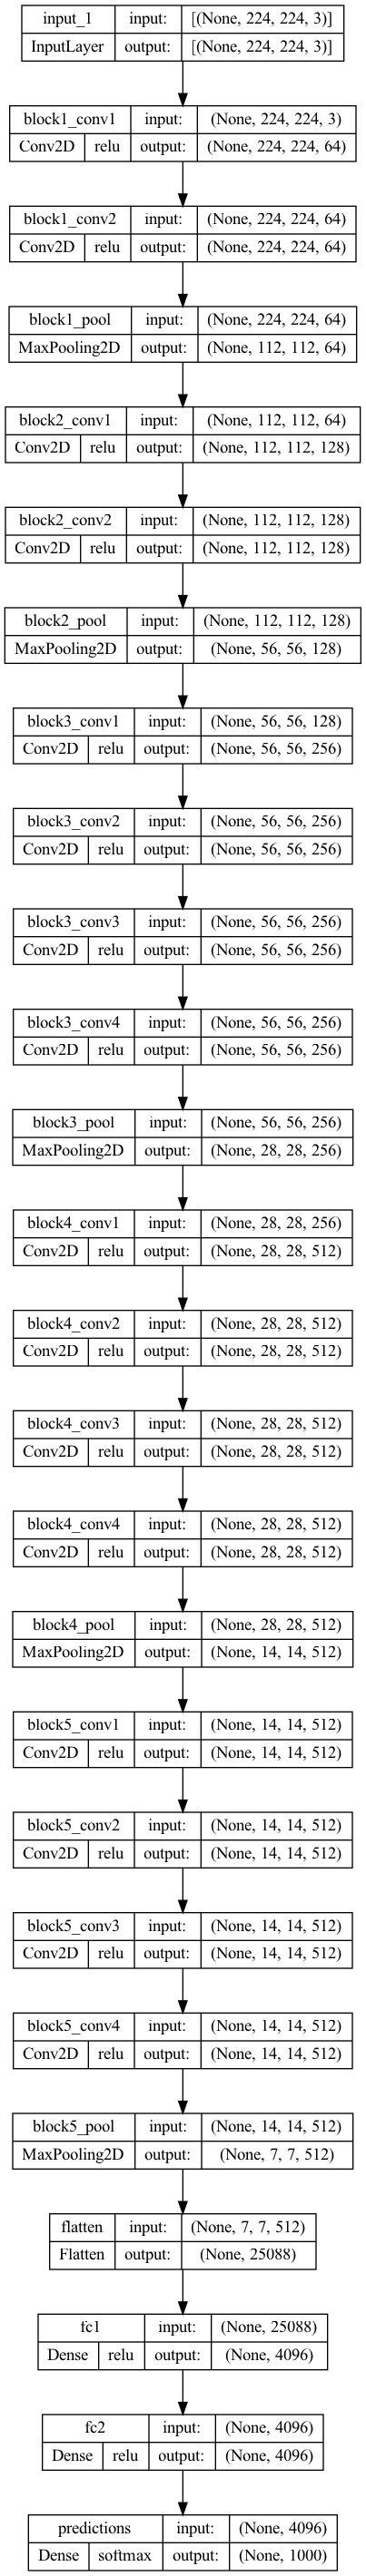

In [11]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg.trainable = False
for i in range(len(vgg.layers)):
    print(vgg.layers[i])
plot_model(vgg,to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

### CNN with Pretrained Model

In [12]:
class CNN(Model):
    def __init__(self, m_name='model'):
        super(CNN, self).__init__(name=m_name)
        self.m_name = m_name
        self.layers_list = []

        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        for i in range(len(vgg.layers)):
            self.layers_list.append(vgg.layers[i])
        self.layers_list.append(keras.layers.Flatten())
        self.layers_list.append(keras.layers.Dense(5, activation="softmax", kernel_initializer=initializer_1, name='out'))
    
    def intermediate_output(self, my_input):
        x = my_input
        for i in range(len(self.layers_list)-4):
            x = self.layers_list[i](x)
        y1, y2 = None, None
        return (y1, y2, x)

    def call(self, inputs, isBuildGraph=False):
        x = inputs
        if(isBuildGraph==False):
            x = self.layers_list[0](x) 

        for i in range(1, len(self.layers_list)):
            x = self.layers_list[i](x)
        return x

    def build_graph(self):
        x = keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNELS), batch_size=batch_size_val, name="Input_layer")
        return Model(inputs=[x], outputs=self.call(x, True), name=self.m_name)

    # Override the name property
    @property
    def name(self):
        return self.m_name


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

2023-05-02 18:27:20.595372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3000


2023-05-02 18:27:28.187995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 8s 858ms/step - loss: 1.2216 - accuracy: 0.6080 - val_loss: 0.6337 - val_accuracy: 0.8200
Epoch 2/3000
8/8 [==============================] - 7s 847ms/step - loss: 0.1328 - accuracy: 0.9640 - val_loss: 0.1004 - val_accuracy: 0.9600
Epoch 3/3000
8/8 [==============================] - 7s 847ms/step - loss: 0.0409 - accuracy: 0.9920 - val_loss: 0.0472 - val_accuracy: 1.0000
Epoch 4/3000
8/8 [==============================] - 7s 851ms/step - loss: 0.0181 - accuracy: 0.9920 - val_loss: 0.0524 - val_accuracy: 0.9800


INFO:tensorflow:Assets written to: model_history/part_b/model_1_4.tf/assets


INFO:tensorflow:Assets written to: model_history/part_b/model_1_4.tf/assets


Epoch 4: early stopping



Training Accuracy for model: 99.20%
Validation Accuracy for model: 98.00%
Test Accuracy for model: 99.00%


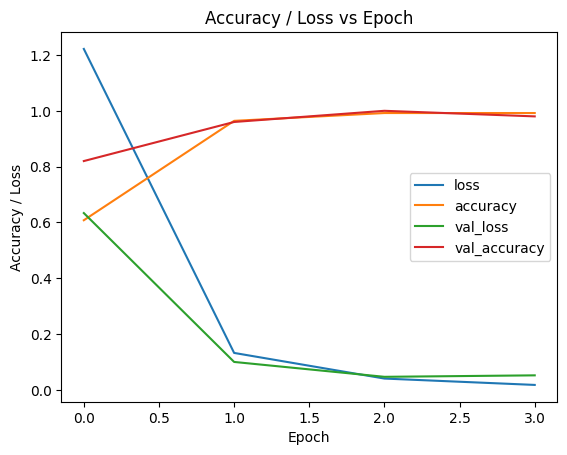

2023-05-02 18:28:00.028083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


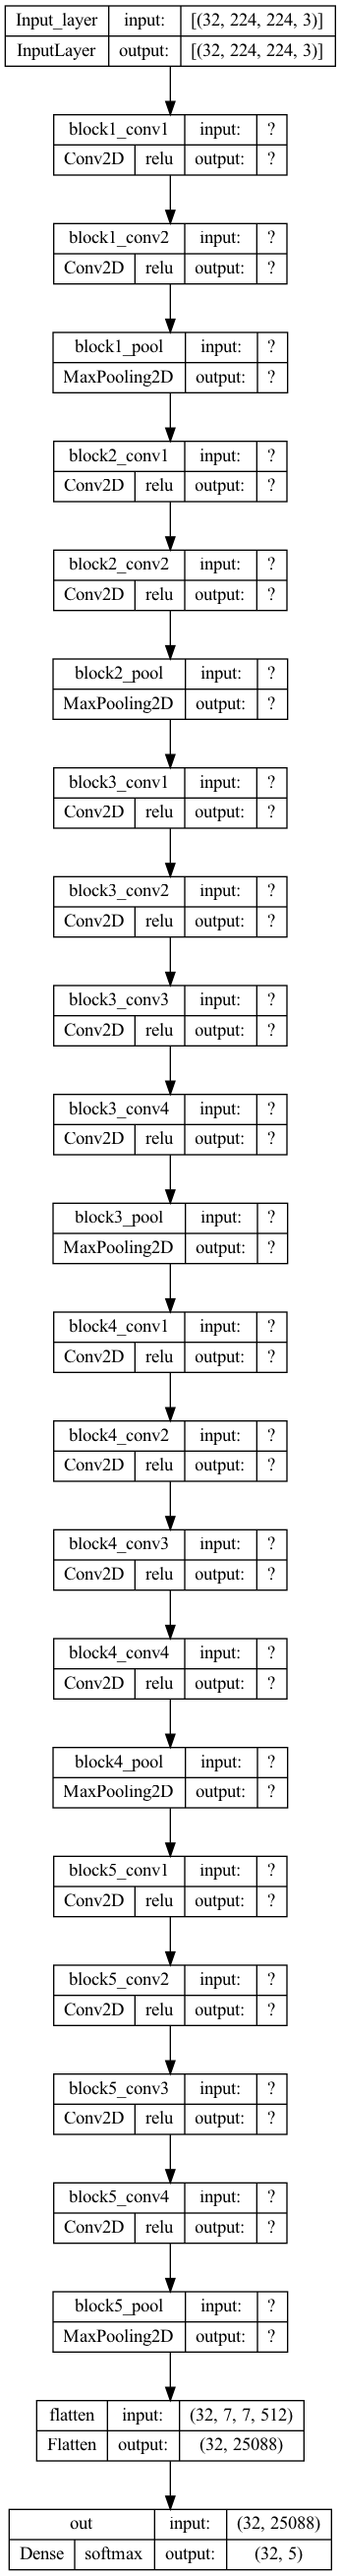

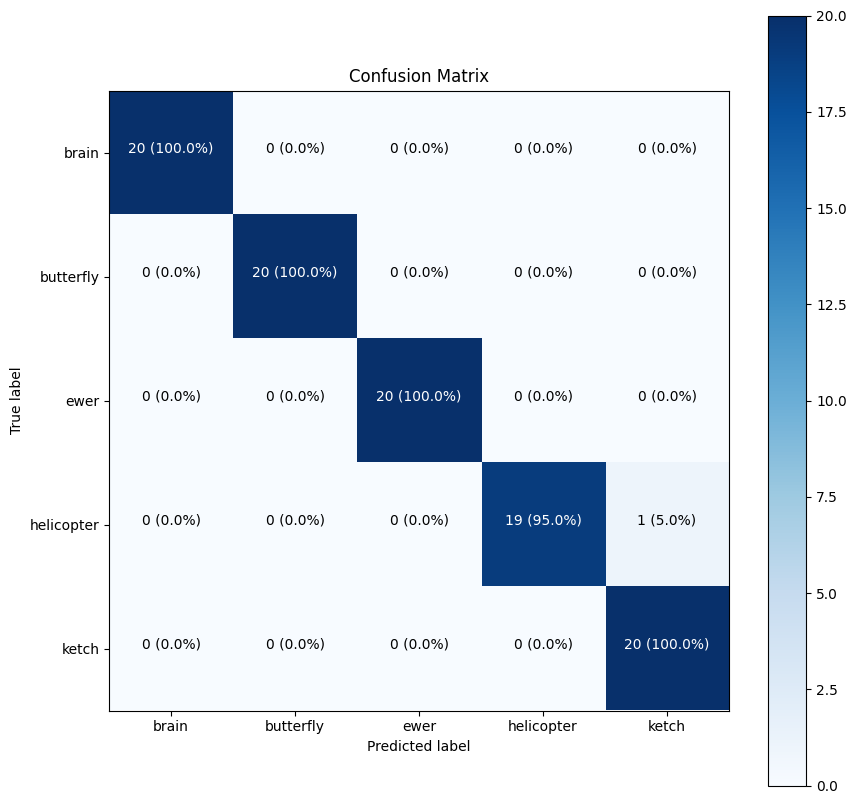

In [13]:
# %%script echo skipping

tf.random.set_seed(random_state_global)

model_1 = CNN(m_name='model_1')

# Build the model

model_1.build(input_shape=(batch_size_val, IMG_SIZE[0], IMG_SIZE[1], CHANNELS))


model_1.summary()

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                    optimizer=keras.optimizers.Adam(),
                    metrics=["accuracy"])

  # Evaluate the model initial losses
initial_train_loss, initial_train_acc = model_1.evaluate(train_data, verbose=0)
initial_valid_loss, initial_valid_acc = model_1.evaluate(valid_data, verbose=0)

# Fit the model
history_2 = model_1.fit(train_data,
                        epochs=epoch_val,
                        validation_data=valid_data,
                        callbacks=[model_saver, HistorySaver((initial_train_loss, initial_train_acc, initial_valid_loss, initial_valid_acc)), early_stopping_cb],
                        verbose=1)

df_history_2 = pd.DataFrame(history_2.history)
showResults(model_1, df_history_2)

# y1, y2, y3 = model_1.intermediate_output(tf.expand_dims(img1, axis=0))
# plotting_output(y1, img1, 'Output of First Convolutional Layer', 0)
# plotting_output(y2, img1, 'Output of Second Convolutional Layer', 4)
# plotting_output(y3, img1, 'Output of Last Convolutional Layer', 8)

plot_model(model_1.build_graph(),to_file=f'model_images/model.png', show_shapes=True, show_layer_activations=True, expand_nested=True)

### Patches that maximally activate a neuron

In [14]:
def get_gradient_for_patch(model, input_image, x, y):
    with tf.GradientTape() as tape:
        # Set the tape to watch the input tensor
        tape.watch(input_image)
        
        # Pass the input tensor through the model
        _,_, intermediate_output = model.intermediate_output(input_image)

        # Get the output neuron we're interested in
        neuron = intermediate_output[:,x,y,:]
        
    # Compute the gradient of the neuron with respect to the input
    gradient = tape.gradient(neuron, input_image)
    
    return gradient

In [15]:
def image_patch_with_max_val_in_last_conv_layer(model, img):
    # Create a random input image
    input_image = tf.expand_dims(img, axis=0)

    # Compute the gradient of the first neuron in the last convolutional layer
    _,_, intermediate_output = model.intermediate_output(input_image)
    max_value = tf.math.reduce_max(intermediate_output)

    # Print the coordinates of the max value
    max_coords = tf.where(tf.equal(intermediate_output, max_value))
    # print("Coordinates of max value:", max_coords.numpy())
    _, x_c, y_c, _ = max_coords.numpy()[0]

    # print(f'last_conv_output shape = {intermediate_output.shape}')
    gradient = get_gradient_for_patch(model_1, input_image, x=x_c, y=y_c)

    # Print the shape of the gradient
    # print(f'gradient shape = {gradient.shape}')

    tensor_var = tf.squeeze(gradient).numpy()
    # Assuming your tensor variable is named 'tensor_var'

    # Find non-zero elements of the tensor variable
    non_zero_indices = tf.where(tf.not_equal(tensor_var, 0))

    # Replace non-zero elements with 255.0 (float)
    updates = tf.ones_like(non_zero_indices[:, 0], dtype=tf.float32) * 255.0
    tensor_var = tf.tensor_scatter_nd_update(tensor_var, non_zero_indices, updates)

    # show image with patch 
    image_with_patch = tensor_var.numpy().astype("uint8")
    # plt.imshow(image_with_patch)
    # plt.show()

    image_countour = tf.squeeze(input_image).numpy().astype("uint8")

    # Convert the image to grayscale
    gray = cv2.cvtColor(image_with_patch, cv2.COLOR_BGR2GRAY)

    # Threshold the image to create a binary image
    ret, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)

    # Find the contours of the patches with pixel value 255
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract the coordinates of the first contour
    contour = contours[0]
    coordinates = np.squeeze(contour)

    # Find the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # for the actual boundary
    # cv2.drawContours(image_countour, [coordinates], 0, (0, 255, 0), 2)

    # Draw the rectangle on the image
    cv2.rectangle(image_countour, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the resulting image
    # plt.imshow(image_countour)
    # plt.axis(False)
    # plt.show()
    return image_countour

In [19]:
def plotting_data(model, image_dict):
    fig, axis = plt.subplots(5, 4, figsize=(10, 12))
    axis = axis.reshape(-1)
    c=0
    for i in range(5):
        for j in range(4):
            k=3
            if(i==0 and j==0):
                k=0
            if(i==0 and j==1):
                k=8
            if(i==1):
                k=0
            if(i==3 and j==0):
                k=1
            img = image_patch_with_max_val_in_last_conv_layer(model_1, image_dict[i][j+k])
            axis[c].imshow(img)
            axis[c].axis(False)
            c+=1
    plt.tight_layout()
    plt.show()



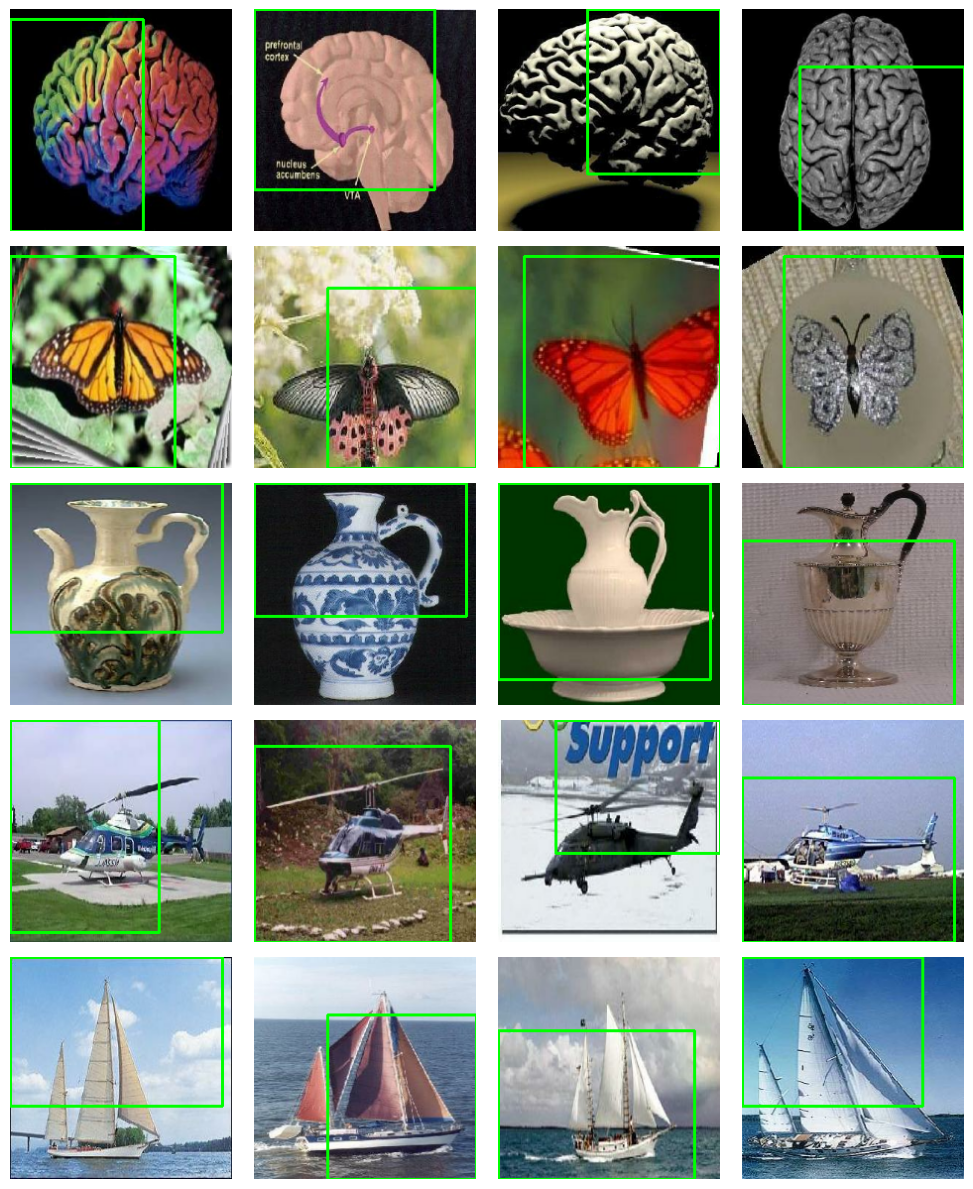

In [22]:
plotting_data(model_1, image_dict)

In [23]:
delete_folder_contents(pathfinal2)